In [100]:
from math import sqrt, sin, cos, tan, atan2
from scipy.fft import fft
from scipy.linalg import svd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, label, generate_binary_structure

plt.rcParams['figure.dpi'] = 200

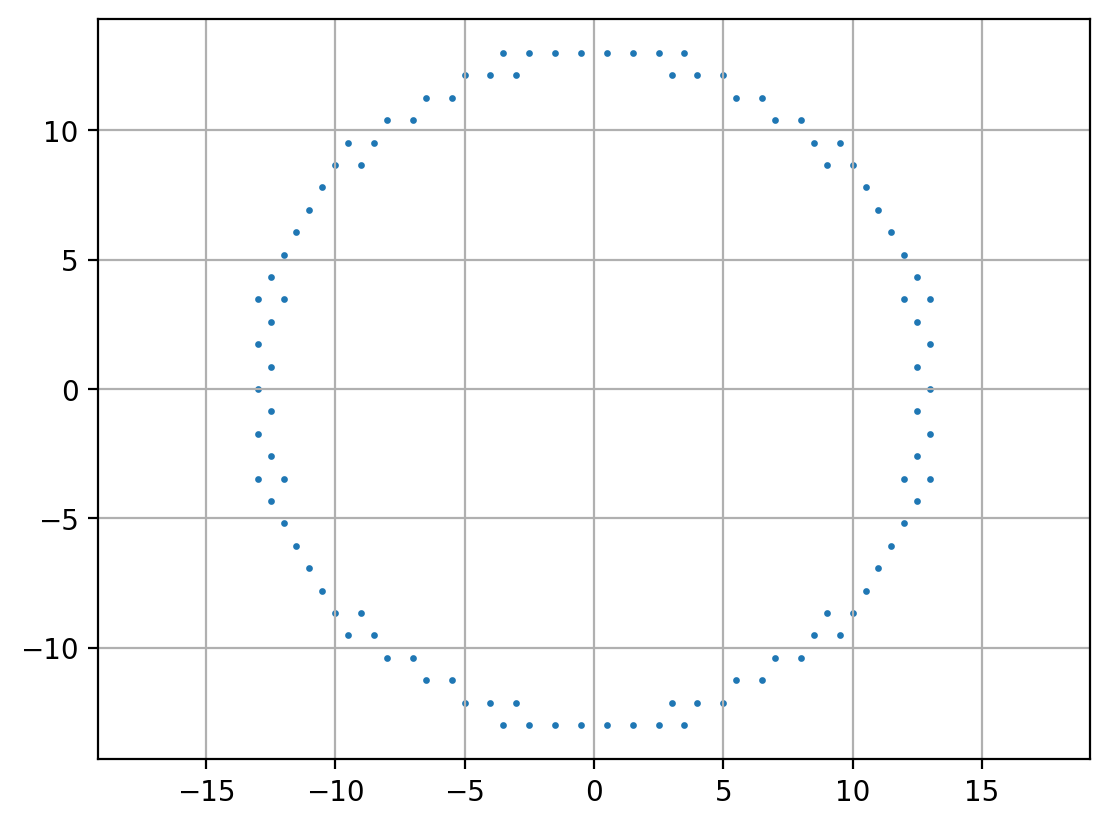

In [101]:
pos_lattice = []
for m in range(-32, 33):
    for n in range(-32, 33):
        if m * m + n * n + m * n in [156, 157, 163, 169, 171, 172, 175, 181]:
            pos_lattice.append((m, n))
pos_lattice = np.array(pos_lattice, dtype=np.int32)

nbSensors = pos_lattice.shape[0]

shear = np.array([[1, 1/2],
                  [0, sqrt(3)/2]])

pos_array = pos_lattice @ shear.T

plt.scatter(pos_array[:, 0], pos_array[:, 1], s=2)
plt.axis('equal')
plt.grid(True)

In [102]:
pos_lattice_coarray_set = set()
for i in range(nbSensors):
    for j in range(nbSensors):
        pos_lattice_coarray_set.add((pos_lattice[i][0] - pos_lattice[j][0], pos_lattice[i][1] - pos_lattice[j][1]))

pos_lattice_coarray_dict = {}
for elem in pos_lattice_coarray_set: pos_lattice_coarray_dict[elem] = []

for i in range(nbSensors):
    for j in range(nbSensors):
        dist = (pos_lattice[i][0] - pos_lattice[j][0], pos_lattice[i][1] - pos_lattice[j][1])
        pos_lattice_coarray_dict[dist].append((i, j))

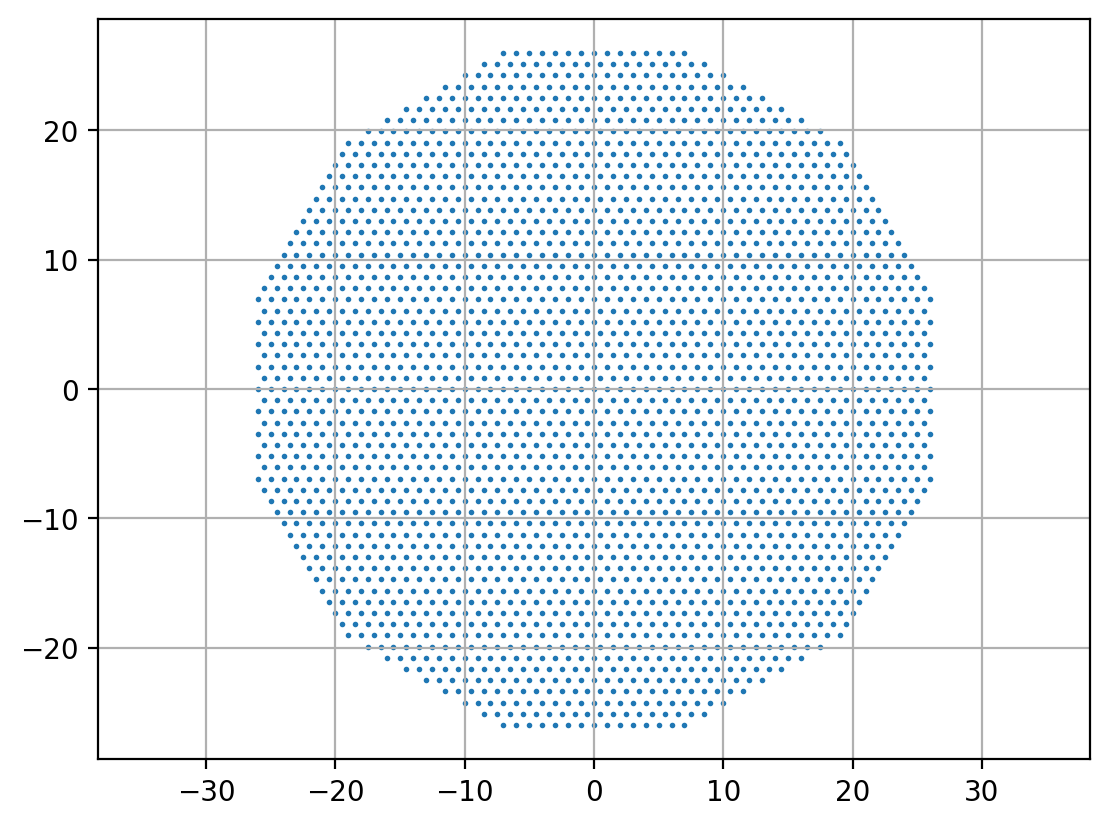

In [103]:
pos_lattice_coarray = np.array(list(pos_lattice_coarray_set), dtype=np.int32)
pos_coarray = pos_lattice_coarray @ shear.T
plt.scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
plt.axis('equal')
plt.grid(True)

In [104]:
t = 200
nbSources = 5
snr = 40

theta = np.random.rand(nbSources) * np.pi / 2
phi = np.random.rand(nbSources) * np.pi 
d_lamda_ratio = 1 / 2

A = np.exp(1j * 2 * np.pi * d_lamda_ratio * (pos_array[:, 0].reshape(-1, 1) * (np.sin(theta) * np.cos(phi)).reshape(1, -1) \
                                           + pos_array[:, 1].reshape(-1, 1) * (np.sin(theta) * np.sin(phi)).reshape(1, -1)))
S = (np.random.randn(nbSources, t) + 1j * np.random.randn(nbSources, t)) / sqrt(2)
N = (np.random.randn(nbSensors, t) + 1j * np.random.randn(nbSensors, t)) / sqrt(2) * 10 ** (-snr/20)

X = A @ S 

R = X @ X.T.conj() / t
coarray_covariance = {}

for pos, indices in pos_lattice_coarray_dict.items():
    indices = np.array(indices)
    values = np.mean(R[indices[:, 0], indices[:, 1]])
    coarray_covariance[pos] = values

In [105]:
import numpy as np
from scipy.linalg import svd
import pymanopt
from pymanopt.manifolds import Product, Euclidean
import pymanopt.optimizers

def low_rank_svd(R, m, n, r, max_iter=1000, tol=1e-6):
    """
    Solve for sigma and SVD of A in R = A + sigma * E using manifold optimization.
    
    Parameters:
    - R: Complex matrix of shape (2m+1, 2n+1)
    - m, n: Integers defining matrix dimensions
    - r: Rank of A
    - max_iter: Maximum iterations
    - tol: Convergence tolerance
    
    Returns:
    - sigma: Scalar value
    - U, S, Vh: SVD components of A (U: (2m+1, r), S: (r,), Vh: (r, 2n+1))
    """
    M, N = 2*m+1, 2*n+1
    E = np.zeros((M, N), dtype=complex)
    E[m, n] = 1.0  # E_{m+1, n+1} = 1 (0-based indexing)

    # Define the product manifold: Euclidean for U, V (full-rank enforced implicitly)
    manifold = Product([Euclidean(M, r, complex=True), Euclidean(N, r, complex=True)])

    # Objective function
    @pymanopt.function.numpy(manifold)
    def cost(U, V):
        UVh = U @ V.conj().T
        sigma = np.maximum(0, np.real(R[m, n] - UVh[m, n]))
        residual = R - UVh - sigma * E
        return 0.5 * np.linalg.norm(residual, 'fro')**2

    # Solve using Riemannian gradient descent
    problem = pymanopt.Problem(manifold=manifold, cost=cost)
    optimizer = pymanopt.optimizers.SteepestDescent(max_iterations=max_iter, min_gradient_norm=tol)
    U, V = optimizer.run(problem).point

    # Compute sigma and A
    UVh = U @ V.conj().T
    sigma = np.maximum(0, np.real(R[m, n] - UVh[m, n]))
    A = R - sigma * E

    # Compute SVD of A
    U_A, S_A, Vh_A = svd(A, full_matrices=False)
    U_A = U_A[:, :r]
    S_A = S_A[:r]
    Vh_A = Vh_A[:r, :]

    return sigma, U_A, S_A, Vh_A

In [106]:
def get_parallelogram(ex, ey):
    limx, limy, sx, sy, MAX = 0, 0, 0, 0, 1
    while (ex[0] * limx, ex[1] * limx) in pos_lattice_coarray_set: limx += 1
    while (ey[0] * limy, ey[1] * limy) in pos_lattice_coarray_set: limy += 1
    for x in range(limx):
        for y in range(limy):
            condition = ((ex[0] * x + ey[0] * y, ex[1] * x + ey[1] * y) in pos_lattice_coarray_set) \
                    and ((- ex[0] * x + ey[0] * y, - ex[1] * x + ey[1] * y) in pos_lattice_coarray_set) \
                    and ((ex[0] * x - ey[0] * y, ex[1] * x - ey[1] * y) in pos_lattice_coarray_set) \
                    and ((- ex[0] * x - ey[0] * y, - ex[1] * x - ey[1] * y) in pos_lattice_coarray_set)
            if  condition: 
                if x * y > MAX: 
                    sx, sy, MAX = x, y, x * y
    pos_parallelogram = []
    for x in range(-sx, sx + 1):
        for y in range(-sy, sy + 1):
            pos_parallelogram.append((ex[0] * x + ey[0] * y, ex[1] * x + ey[1] * y)) 
    return pos_parallelogram, sx, sy


def MUSIC_peak_finding_2D(spectrum, d: int):

    neighborhood = generate_binary_structure(2, 2)
    local_max = (spectrum == maximum_filter(spectrum, footprint=neighborhood))
    labeled_peaks, _ = label(local_max)
    peak_coords = np.argwhere(labeled_peaks)
    peak_coords_flatten = peak_coords[:, 0] * spectrum.shape[1] + peak_coords[:, 1]
    spectrum_flatten = spectrum.flatten()
    sort_idx = np.argsort(-spectrum_flatten[peak_coords_flatten])
    selected_coords_sort = peak_coords_flatten[sort_idx][:d]
    peak_coords_theta = selected_coords_sort // spectrum.shape[1]
    peak_coords_phi = selected_coords_sort % spectrum.shape[1]
    return peak_coords_phi, peak_coords_theta 


def plot_spectrum(axe, spectrum, phi_space, theta_space, phi_true, theta_true):
    
    phi_plot, theta_plot = np.meshgrid(phi_space, theta_space)
    spectrum = 10 * np.log10(spectrum / np.max(spectrum))  
    
    contour = axe.contourf(phi_plot, theta_plot, spectrum.T, levels=50, cmap='viridis')

    peak_coords_phi, peak_coords_theta = MUSIC_peak_finding_2D(spectrum.T, phi_true.shape[-1])
    phi_predicted = phi_space[peak_coords_phi]
    theta_predicted = theta_space[peak_coords_theta]

    axe.scatter(phi_true, theta_true, color='red', marker='o', label="Target")
    axe.scatter(phi_predicted, theta_predicted, color='orange', marker='x', label="Peak")

    axe.set_xlabel('Azimuth (rad)')
    axe.set_ylabel('Elevation (rad)')
    axe.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

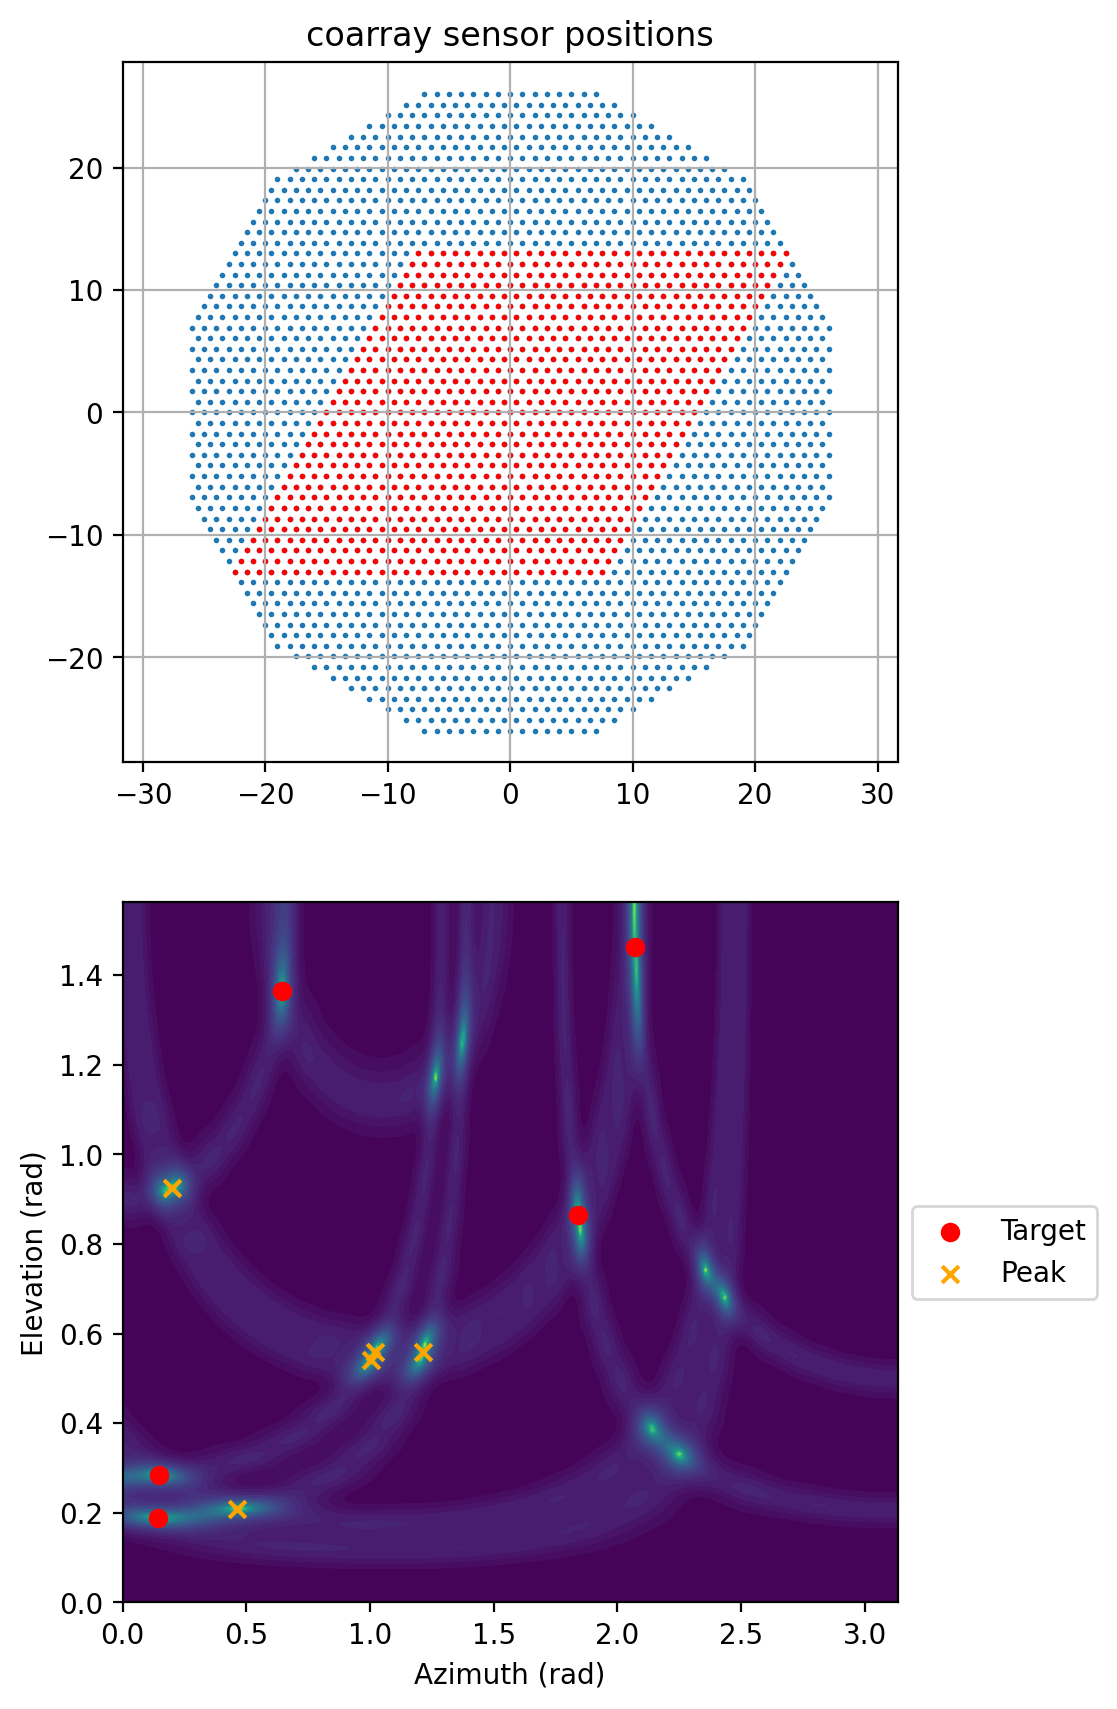

<Figure size 1280x960 with 0 Axes>

In [107]:
pos_lattice_coarray_set_0_60, sx_0_60, sy_0_60 = get_parallelogram((1, 0), (0, 1))
pos_lattice_coarray_0_60 = np.array(list(pos_lattice_coarray_set_0_60))
pos_coarray_0_60 = pos_lattice_coarray_0_60 @ shear.T

R = [coarray_covariance[(pos[0], pos[1])].conj() for pos in pos_lattice_coarray_0_60]
R = np.array(R).reshape(2 * sx_0_60 + 1, 2 * sy_0_60 + 1)
U_svd_0_60, _, Vh_svd_0_60 = np.linalg.svd(R)

phi_discretized = np.linspace(0, np.pi, 360, endpoint=False)
theta_discretized = np.linspace(0, np.pi/2, 180, endpoint=False)

U_0_60 = np.exp(-1j * 2 * np.pi * d_lamda_ratio * np.cos(phi_discretized - 0).reshape(1, -1, 1)
                                                * np.sin(theta_discretized).reshape(1, 1, -1)
                                                * np.arange(-sx_0_60, sx_0_60+1).reshape(-1, 1, 1))

V_0_60 = np.exp(1j * 2 * np.pi * d_lamda_ratio * np.cos(phi_discretized - np.pi / 3).reshape(1, -1, 1)
                                               * np.sin(theta_discretized).reshape(1, 1, -1)
                                               * np.arange(-sy_0_60, sy_0_60+1).reshape(-1, 1, 1))

spectrum_0_60 = 1 / (np.linalg.norm(np.einsum('ij,ikl->jkl', U_svd_0_60[:, nbSources:].conj(), U_0_60), axis=0) ** 2 + 
                     np.linalg.norm(np.einsum('ji,ikl->jkl', Vh_svd_0_60[nbSources:, :], V_0_60), axis=0) ** 2)

fig, axes = plt.subplots(2, 1, figsize=(5, 10))

# first subplot
axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
axes[0].scatter(pos_coarray_0_60[:, 0], pos_coarray_0_60[:, 1], s=1, color='red')
axes[0].set_title('coarray sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# second subplot
plot_spectrum(axes[1], spectrum_0_60, phi_discretized, theta_discretized, phi, theta)

# Improve layout
plt.tight_layout()
plt.show()

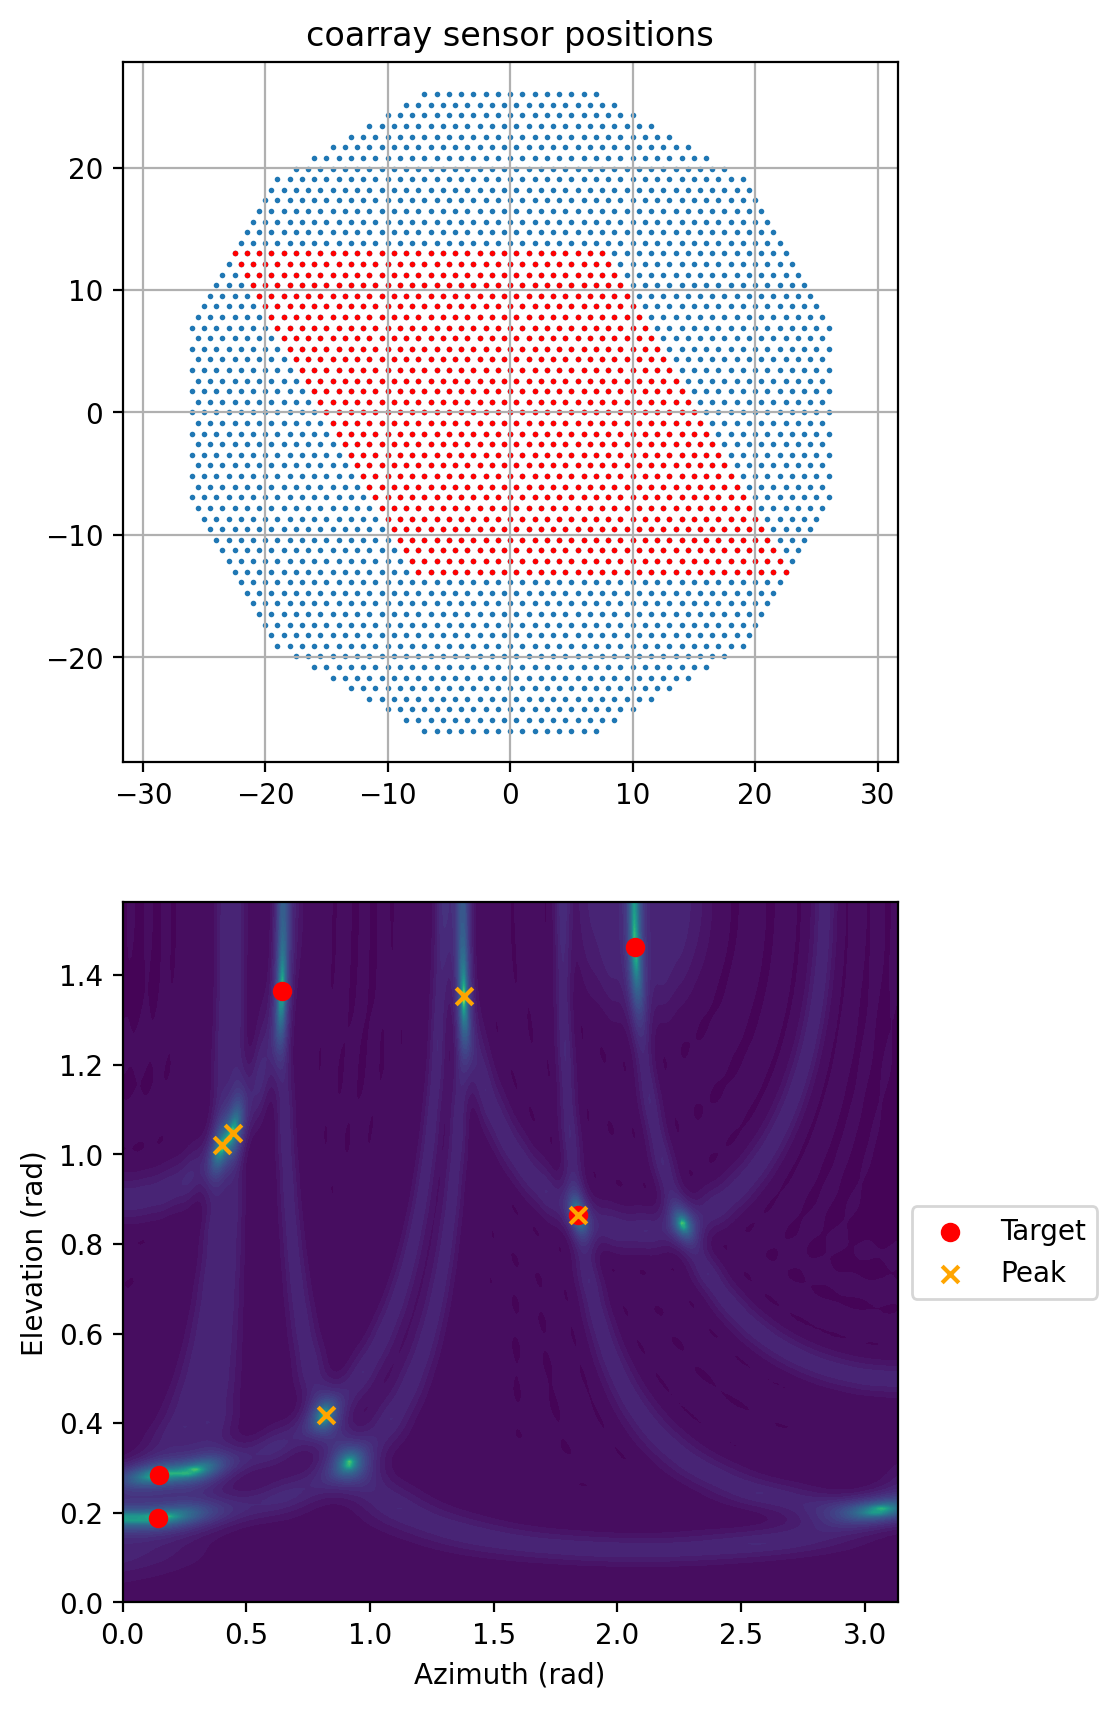

<Figure size 1280x960 with 0 Axes>

In [108]:
pos_lattice_coarray_set_0_120, sx_0_120, sy_0_120 = get_parallelogram((1, 0), (-1, 1))
pos_lattice_coarray_0_120 = np.array(list(pos_lattice_coarray_set_0_120))
pos_coarray_0_120 = pos_lattice_coarray_0_120 @ shear.T

R = [coarray_covariance[(pos[0], pos[1])].conj() for pos in pos_lattice_coarray_0_120]
R = np.array(R).reshape(2 * sx_0_120 + 1, 2 * sy_0_120 + 1)
U_svd_0_120, _, Vh_svd_0_120 = np.linalg.svd(R)

phi_discretized = np.linspace(0, np.pi, 360, endpoint=False)
theta_discretized = np.linspace(0, np.pi/2, 180, endpoint=False)

U_0_120 = np.exp(-1j * 2 * np.pi * d_lamda_ratio * np.cos(phi_discretized - 0).reshape(1, -1, 1)
                                                 * np.sin(theta_discretized).reshape(1, 1, -1)
                                                 * np.arange(-sx_0_120, sx_0_120+1).reshape(-1, 1, 1))

V_0_120 = np.exp(1j * 2 * np.pi * d_lamda_ratio * np.cos(phi_discretized - 2 * np.pi / 3).reshape(1, -1, 1)
                                                * np.sin(theta_discretized).reshape(1, 1, -1)
                                                * np.arange(-sy_0_120, sy_0_120+1).reshape(-1, 1, 1))

spectrum_0_120 = 1 / (np.linalg.norm(np.einsum('ij,ikl->jkl', U_svd_0_120[:, nbSources:].conj(), U_0_120), axis=0) ** 2 + 
                      np.linalg.norm(np.einsum('ji,ikl->jkl', Vh_svd_0_120[nbSources:, :], V_0_120), axis=0) ** 2)

fig, axes = plt.subplots(2, 1, figsize=(5, 10))

# first subplot
axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
axes[0].scatter(pos_coarray_0_120[:, 0], pos_coarray_0_120[:, 1], s=1, color='red')
axes[0].set_title('coarray sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# second subplot
plot_spectrum(axes[1], spectrum_0_120, phi_discretized, theta_discretized, phi, theta)

# Improve layout
plt.tight_layout()
plt.show()

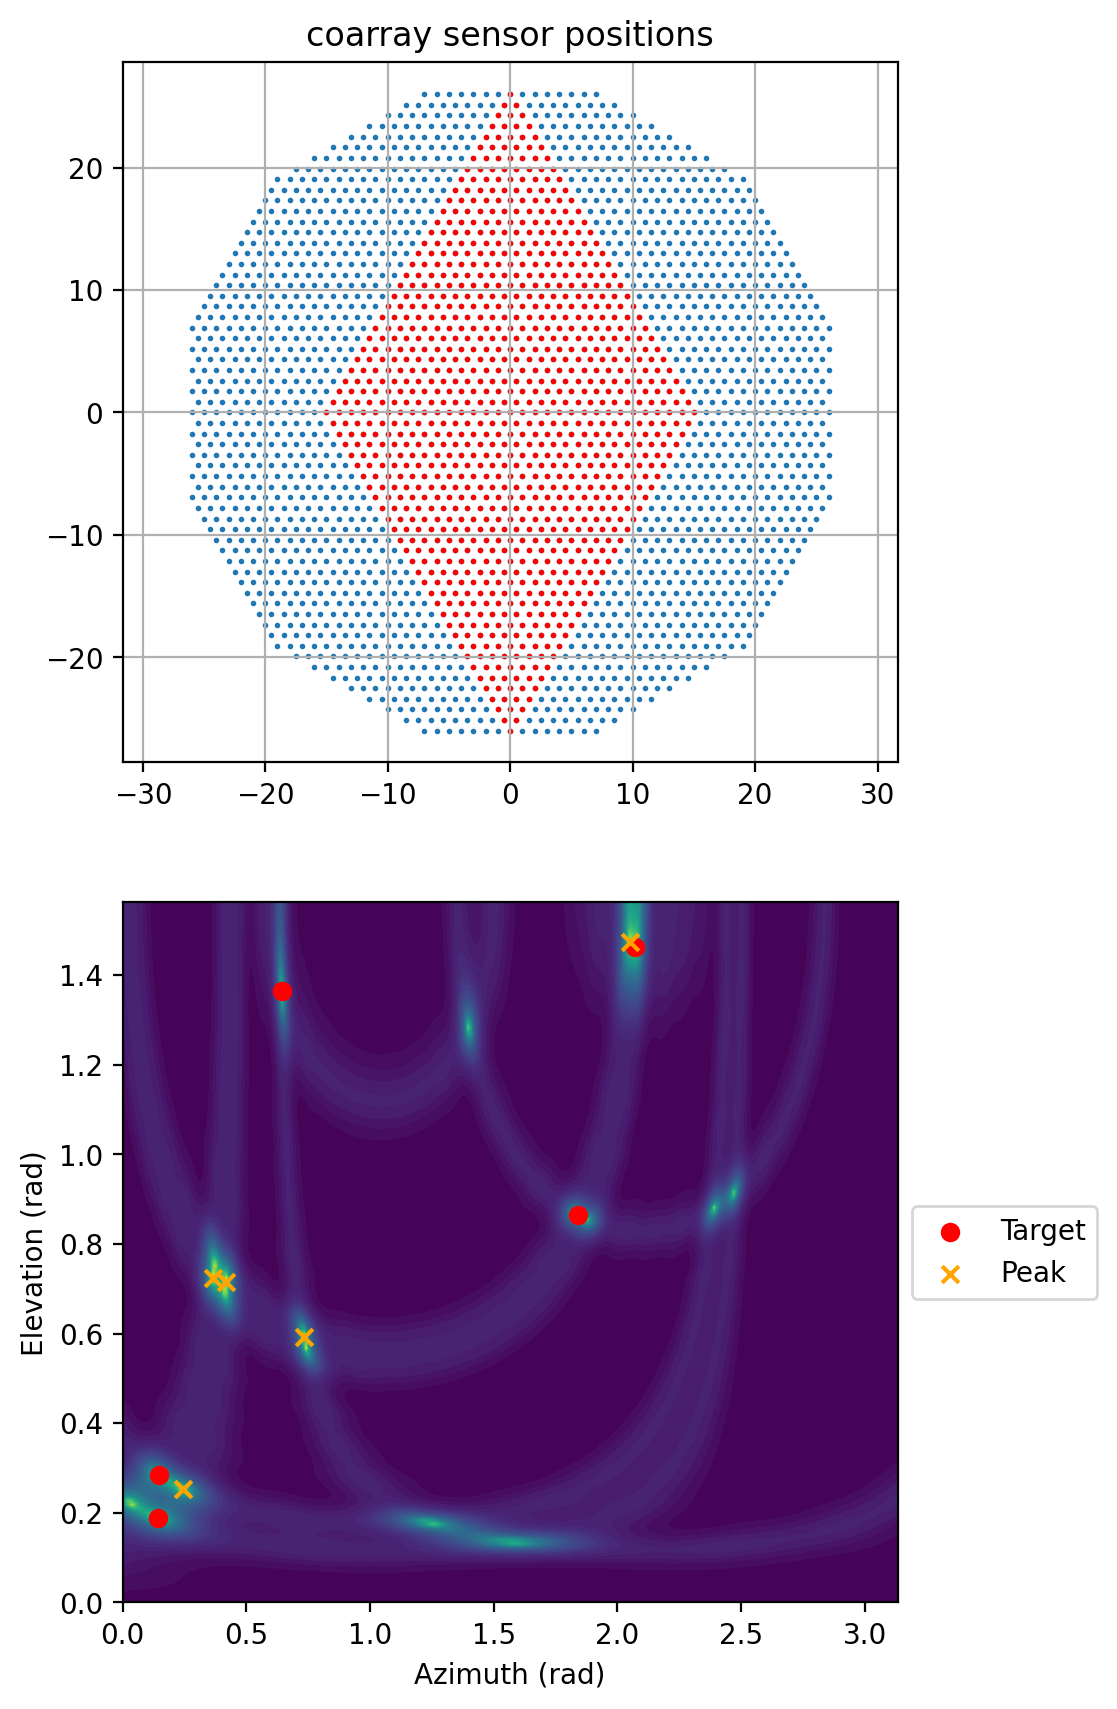

<Figure size 1280x960 with 0 Axes>

In [109]:
pos_lattice_coarray_set_60_120, sx_60_120, sy_60_120 = get_parallelogram((0, 1), (-1, 1))
pos_lattice_coarray_60_120 = np.array(list(pos_lattice_coarray_set_60_120))
pos_coarray_60_120 = pos_lattice_coarray_60_120 @ shear.T

R = [coarray_covariance[(pos[0], pos[1])].conj() for pos in pos_lattice_coarray_60_120]
R = np.array(R).reshape(2 * sx_60_120 + 1, 2 * sy_60_120 + 1)
U_svd_60_120, _, Vh_svd_60_120 = np.linalg.svd(R)

phi_discretized = np.linspace(0, np.pi, 360, endpoint=False)
theta_discretized = np.linspace(0, np.pi/2, 180, endpoint=False)

U_60_120 = np.exp(-1j * 2 * np.pi * d_lamda_ratio * np.cos(phi_discretized - np.pi / 3).reshape(1, -1, 1)
                                                  * np.sin(theta_discretized).reshape(1, 1, -1)
                                                  * np.arange(-sx_60_120, sx_60_120+1).reshape(-1, 1, 1))

V_60_120 = np.exp(1j * 2 * np.pi * d_lamda_ratio * np.cos(phi_discretized - 2 * np.pi / 3).reshape(1, -1, 1)
                                                 * np.sin(theta_discretized).reshape(1, 1, -1)
                                                 * np.arange(-sy_60_120, sy_60_120+1).reshape(-1, 1, 1))

spectrum_60_120 = 1 / (np.linalg.norm(np.einsum('ij,ikl->jkl', U_svd_60_120[:, nbSources:].conj(), U_60_120), axis=0) ** 2 + 
                       np.linalg.norm(np.einsum('ji,ikl->jkl', Vh_svd_60_120[nbSources:, :], V_60_120), axis=0) ** 2)

fig, axes = plt.subplots(2, 1, figsize=(5, 10))

# first subplot
axes[0].scatter(pos_coarray[:, 0], pos_coarray[:, 1], s=1)
axes[0].scatter(pos_coarray_60_120[:, 0], pos_coarray_60_120[:, 1], s=1, color='red')
axes[0].set_title('coarray sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# second subplot
plot_spectrum(axes[1], spectrum_60_120, phi_discretized, theta_discretized, phi, theta)

# Improve layout
plt.tight_layout()
plt.show()

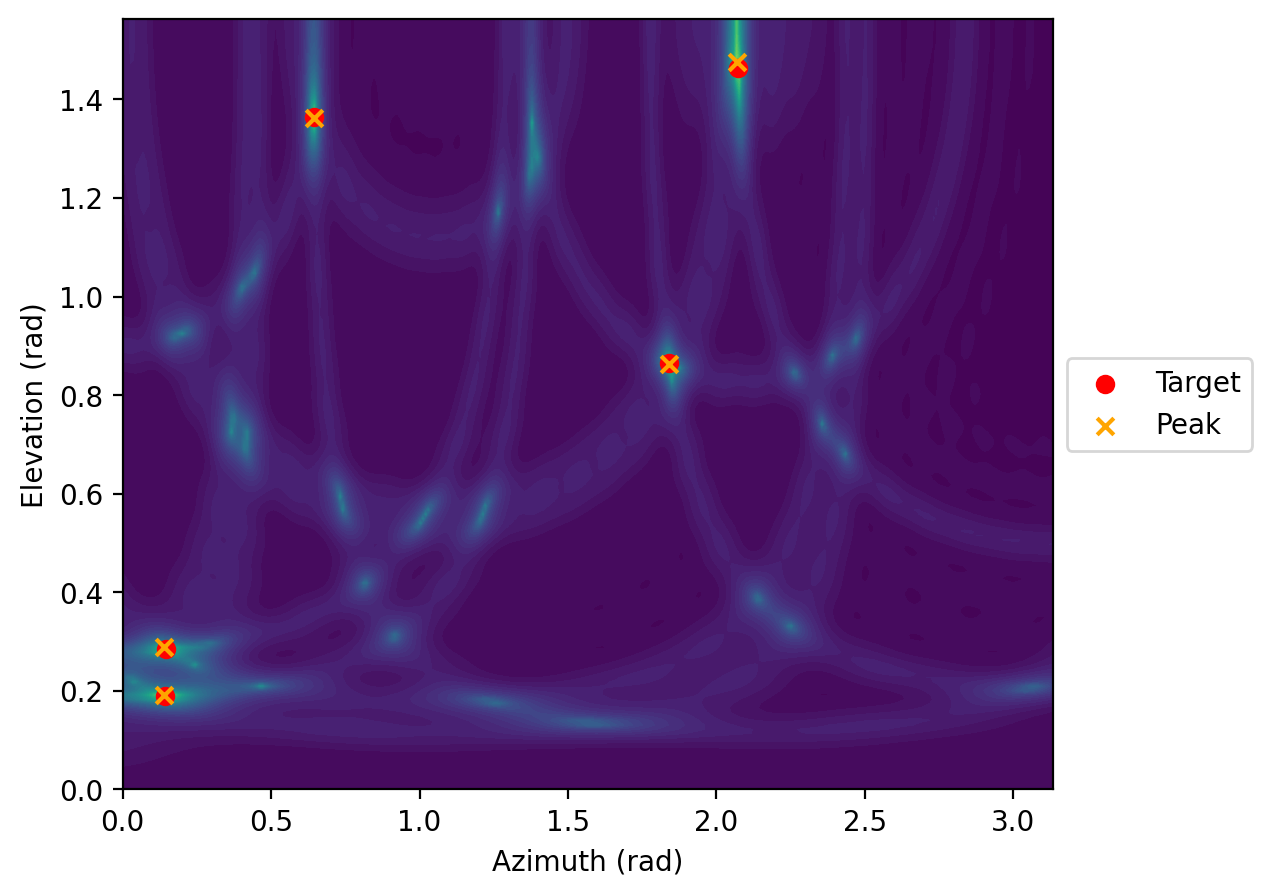

<Figure size 1280x960 with 0 Axes>

In [110]:
fig, axe = plt.subplots(1, 1, figsize=(6, 5))

# second subplot
plot_spectrum(axe, spectrum_60_120 * spectrum_0_120 * spectrum_0_60, phi_discretized, theta_discretized, phi, theta)

# Improve layout
plt.tight_layout()
plt.show()